In [22]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import yfinance as yf

In [60]:
import yfinance as yf
import pandas as pd

eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df = df[['Close']]  

df.reset_index(inplace=True)
df.rename(columns={"Date": "date", "Close": "value"}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype('float32')

df.set_index("date", inplace=True)
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='d')

df = df.reindex(full_index)

df.fillna(method='ffill', inplace=True)

df.head()

C:\Users\krzys\AppData\Local\Temp\ipykernel_4648\3480218818.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,value
1993-08-12 00:00:00-04:00,2.754306
1993-08-13 00:00:00-04:00,2.670114
1993-08-14 00:00:00-04:00,2.670114
1993-08-15 00:00:00-04:00,2.670114
1993-08-16 00:00:00-04:00,2.694168


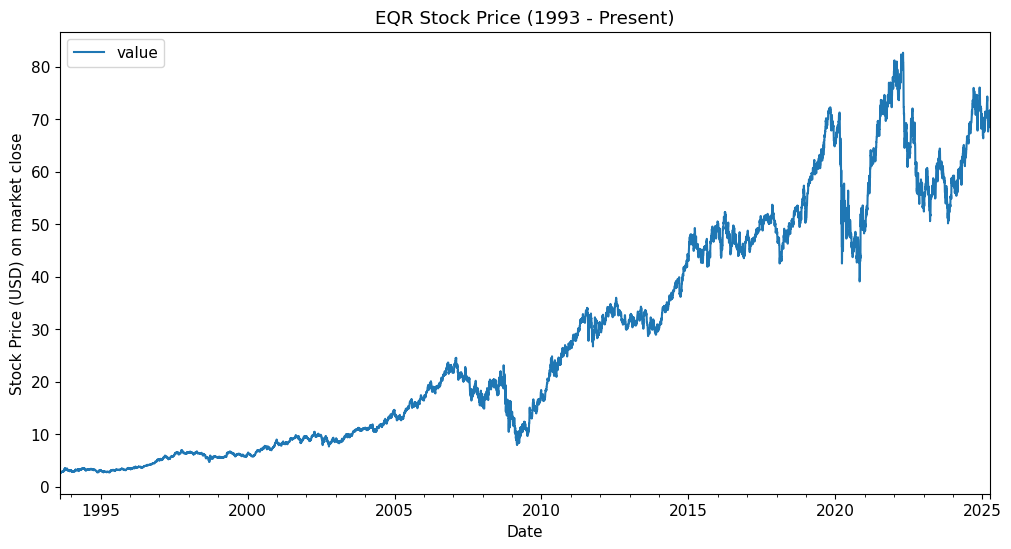

In [61]:
df.plot(title='EQR Stock Price (1993 - Present)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Stock Price (USD) on market close')
plt.show()

In [62]:
train_end = round(len(df) * 0.7)
valid_end = round(len(df) * 0.9)

train = PandasDataset(df[:train_end], freq="d", target="value")
valid = PandasDataset(df[train_end:valid_end], freq="d", target="value")
test = PandasDataset(df[valid_end:], freq="d", target="value")

In [63]:
#predict next week
prediction_length = 7
context_length = prediction_length * 3
num_samples = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [31]:
import os
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [33]:
ckpt = torch.load('lag-llama.ckpt', map_location=device, weights_only=False)
estimator_args = ckpt['hyper_parameters']['model_kwargs']

zs_estimator = LagLlamaEstimator(
    ckpt_path='lag-llama.ckpt',
    prediction_length=prediction_length,
    context_length=context_length,
    device=device,

    #estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],

    nonnegative_pred_samples=True,

    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },
    batch_size=batch_size,
    num_parallel_samples=num_samples
)

zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

c:\Users\krzys\miniconda3\Lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.


In [34]:
date_list = pd.date_range(df[valid_end:].index[60], periods=9, freq="30d").tolist()
print(date_list)
zs_forecasts = []
zs_tss = []


for d in date_list:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="d", target="value"),
        predictor=zs_predictor,
        num_samples=num_samples
    )

    zs_forecasts.append(list(forecast_it))
    zs_tss.append(list(ts_it))

[Timestamp('2022-04-04 00:00:00-0400', tz='America/New_York'), Timestamp('2022-05-04 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-07-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-02 00:00:00-0400', tz='America/New_York'), Timestamp('2022-09-01 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-01 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-31 00:00:00-0400', tz='America/New_York'), Timestamp('2022-11-30 00:00:00-0500', tz='America/New_York')]


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(f

In [64]:
evaluator = Evaluator()
zs_a_metrics = [] 
zs_t_metrics = []

for (t, s) in zip(zs_tss, zs_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    zs_a_metrics.append(agg_metrics)
    zs_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00, 125.05it/s]
Running evaluation: 1it [00:00, 124.97it/s]
Running evaluation: 1it [00:00, 166.61it/s]
Running evaluation: 1it [00:00, 142.30it/s]
Running evaluation: 1it [00:00, 142.78it/s]
Running evaluation: 1it [00:00, 124.93it/s]
Running evaluation: 1it [00:00, 142.87it/s]
Running evaluation: 1it [00:00, 166.65it/s]
Running evaluation: 1it [00:00, 124.50it/s]


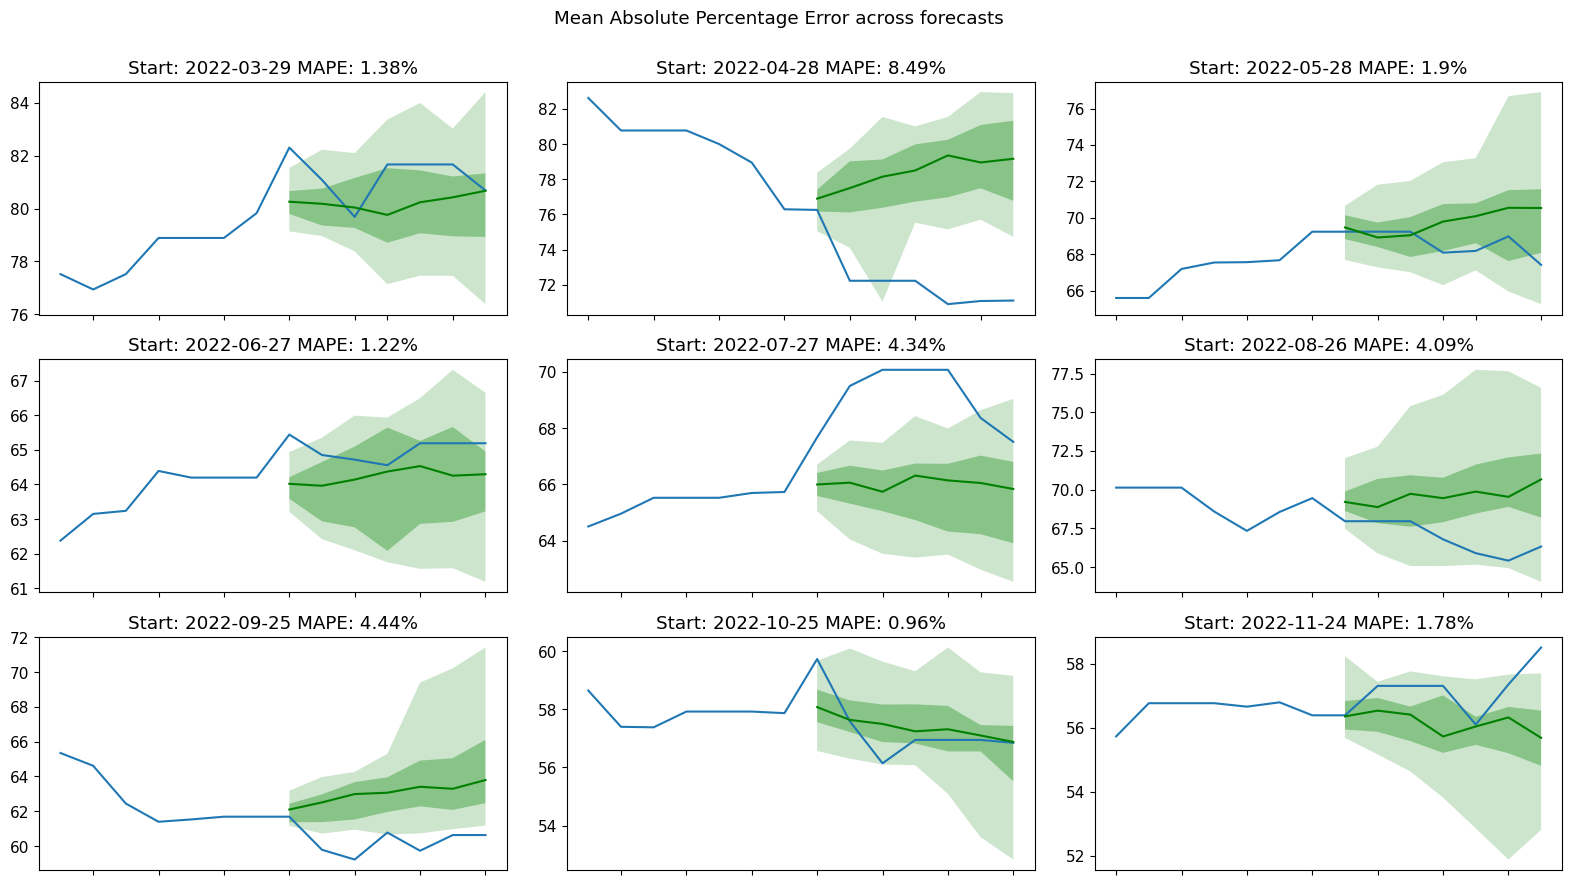

Average MAPE: 3.18


In [47]:
plt.figure(figsize=(16, 9))

plt.rcParams.update({'font.size': 11})

smapes = []

for idx in range(len(zs_forecasts)):
    ax = plt.subplot(3, 3, idx+1)
    t = zs_tss[idx][0][zs_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

    smape = float(f'{zs_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')
    smapes.append(smape)
    ax.set_title("Start: " + str(zs_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t[0])
    ax.set_xticklabels([])

    zs_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f'Average MAPE: {sum(smapes) / len(smapes):.2f}')

In [83]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

finetune_estimator = LagLlamaEstimator(
    # ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=64,

    nonnegative_pred_samples=True,
    aug_prob=0,
    lr=5e-4,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=6,
    n_embd_per_head=64,
    n_head=8,
    time_feat=estimator_args["time_feat"],

    # linear positional encoding scaling
    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },

    batch_size=128,
    num_parallel_samples=num_samples,
    trainer_kwargs = {"max_epochs": 50,} # lightning trainer arguments
)

C:\Users\krzys\AppData\Local\Temp\ipykernel_4648\442431810.py:1: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


In [84]:
finetuned_predictor = finetune_estimator.train(train, valid, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 20.5 M
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
20.5 M    Trainable params
0         Non-trainable params
20.5 M    Total params
82.012    Total estimated model params size (MB)


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:19<00:00,  2.51it/s, v_num=4]

Epoch 0, global step 50: 'val_loss' reached 4.00625 (best 4.00625), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:19<00:00,  2.51it/s, v_num=4]

Epoch 1, global step 100: 'val_loss' reached 3.19057 (best 3.19057), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:19<00:00,  2.50it/s, v_num=4]

Epoch 2, global step 150: 'val_loss' was not in top 1


Epoch 3: |          | 50/? [00:19<00:00,  2.50it/s, v_num=4]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:19<00:00,  2.50it/s, v_num=4]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:19<00:00,  2.50it/s, v_num=4]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:19<00:00,  2.50it/s, v_num=4]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 10, global step 550: 'val_loss' reached 2.61614 (best 2.61614), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:19<00:00,  2.50it/s, v_num=4]

Epoch 12, global step 650: 'val_loss' reached 2.30152 (best 2.30152), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 15, global step 800: 'val_loss' reached 2.21269 (best 2.21269), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 16, global step 850: 'val_loss' reached 2.16650 (best 2.16650), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 18, global step 950: 'val_loss' reached 2.13228 (best 2.13228), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 22, global step 1150: 'val_loss' reached 2.09804 (best 2.09804), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 23, global step 1200: 'val_loss' reached 2.02055 (best 2.02055), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 26, global step 1350: 'val_loss' reached 1.90329 (best 1.90329), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 27, global step 1400: 'val_loss' reached 1.79399 (best 1.79399), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 28, global step 1450: 'val_loss' reached 1.63693 (best 1.63693), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 29, global step 1500: 'val_loss' reached 1.63558 (best 1.63558), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 31, global step 1600: 'val_loss' reached 1.60132 (best 1.60132), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 37, global step 1900: 'val_loss' reached 1.54959 (best 1.54959), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 39, global step 2000: 'val_loss' reached 1.48883 (best 1.48883), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 42, global step 2150: 'val_loss' reached 1.45326 (best 1.45326), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_4\\checkpoints\\epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:20<00:00,  2.50it/s, v_num=4]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]

Epoch 49, global step 2500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:20<00:00,  2.49it/s, v_num=4]


c:\Users\krzys\miniconda3\Lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.


In [88]:
date_list = pd.date_range(df[valid_end:].index[0], periods=9, freq="30d").tolist()

finetune_forecasts = []
finetune_tss = []

for d in date_list:
    print(d)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="1d", target="value"),
        predictor=finetuned_predictor,
        num_samples=num_samples
    )
    finetune_forecasts.append(list(forecast_it))
    finetune_tss.append(list(ts_it))

2022-02-03 00:00:00-05:00


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(f

2022-03-05 00:00:00-05:00
2022-04-04 00:00:00-04:00


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


2022-05-04 00:00:00-04:00
2022-06-03 00:00:00-04:00


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


2022-07-03 00:00:00-04:00
2022-08-02 00:00:00-04:00


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


2022-09-01 00:00:00-04:00
2022-10-01 00:00:00-04:00


c:\Users\krzys\miniconda3\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


In [89]:
evaluator = Evaluator()
finetune_a_metrics = [] 
finetune_t_metrics  = []

for (t, s) in zip(finetune_tss, finetune_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    finetune_a_metrics.append(agg_metrics)
    finetune_t_metrics .append(ts_metrics)

Running evaluation: 1it [00:00, 100.02it/s]
Running evaluation: 1it [00:00, 100.00it/s]
Running evaluation: 1it [00:00, 111.06it/s]
Running evaluation: 1it [00:00, 100.00it/s]
Running evaluation: 1it [00:00, 111.12it/s]
Running evaluation: 1it [00:00, 99.99it/s]
Running evaluation: 1it [00:00, 125.04it/s]
Running evaluation: 1it [00:00, 125.02it/s]
Running evaluation: 1it [00:00, 100.05it/s]


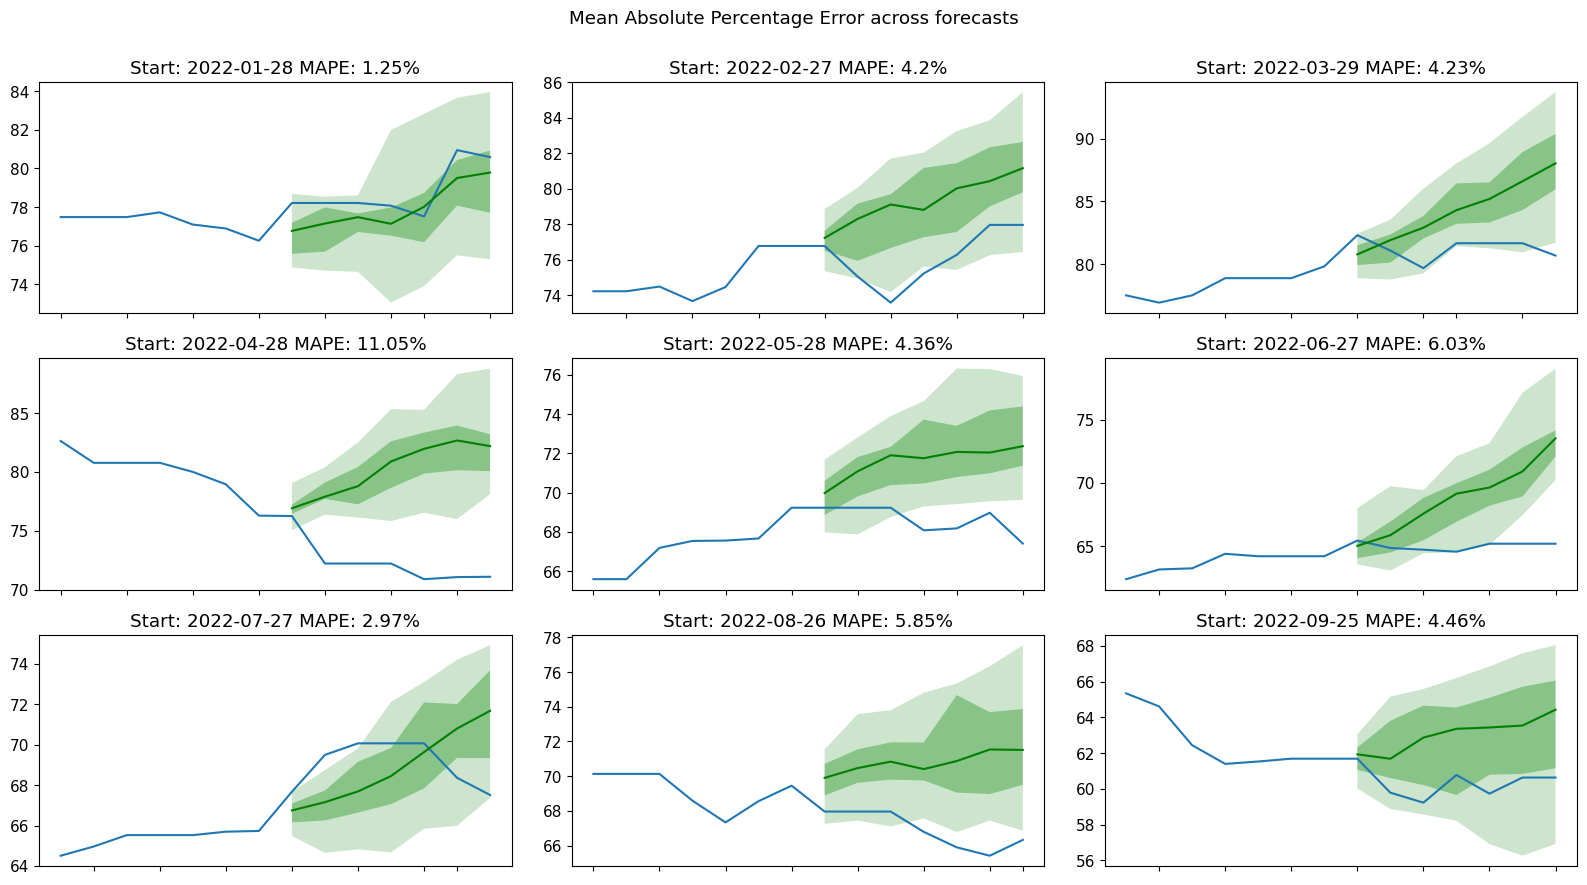

Average MAPE: 4.93


In [90]:
plt.figure(figsize=(16, 9))

plt.rcParams.update({'font.size': 11})
smapes = []

for idx in range(len(finetune_forecasts)):
    ax = plt.subplot(3, 3, idx+1)
    t = finetune_tss[idx][0][finetune_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

    smape = float(f'{finetune_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')
    smapes.append(smape)
    ax.set_title("Start: " + str(finetune_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t[0])
    ax.set_xticklabels([])

    finetune_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f'Average MAPE: {sum(smapes)/len(smapes):.2f}')


Original Model is still better, but maybe some more training could be done
- training with parameter from original model: Average MAPE: 4.79
- training with newly chosen parameters (in code): Average MAPE: 4.93